In [3]:
from autoencodeSVJ import utils, models, trainer
import glob
import os
import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

version_id = 'v5'
SEED = 42

In [4]:
# get h5 datasets
data_path = "data/tightSVJ/10h5/*_data.h5"
signal_path = "data/signal/fullh5/*_data.h5"

data, data_tags, data_jets = utils.load_all_data(data_path, "background")
signal, signal_tags, signal_jets = utils.load_all_data(signal_path, "signal")

split = 0.25

train, test = data.train_test_split(split, SEED)
utils.compare_tags([train, test, data, signal])

data_raw = data.cdrop("*Flavor")
signal_raw = signal.cdrop("*Flavor")
train_raw = train.cdrop("*Flavor")
test_raw = test.cdrop("*Flavor")

norm_args = {"norm_type": "StandardScaler"}
train_norm, test_norm = train_raw.norm(**norm_args), train_raw.norm(test_raw, **norm_args)
data_norm, signal_norm = train_raw.norm(data_raw, **norm_args), train_raw.norm(signal_raw, **norm_args)

background tags:

down jet: 18999, 18.4%
up jet: 38841, 37.6%
strange jet: 25377, 24.5%
charm jet: 9577, 9.3%
bottom jet: 3341, 3.2%
gluon jet: 7281, 7.0%

signal tags:

down jet: 1220, 2.5%
up jet: 1866, 3.8%
strange jet: 1550, 3.1%
charm jet: 3344, 6.8%
bottom jet: 38995, 78.8%
gluon jet: 2541, 5.1%

bottom:
	3.3% (2539) train
	3.1% (802) test
	3.2% (3341) background
	78.8% (38995) signal
up:
	37.4% (28973) train
	38.2% (9868) test
	37.6% (38841) background
	3.8% (1866) signal
down:
	18.4% (14285) train
	18.2% (4714) test
	18.4% (18999) background
	2.5% (1220) signal
strange:
	24.6% (19069) train
	24.4% (6308) test
	24.5% (25377) background
	3.1% (1550) signal
charm:
	9.3% (7238) train
	9.0% (2339) test
	9.3% (9577) background
	6.8% (3344) signal
gluon:
	7.0% (5458) train
	7.1% (1823) test
	7.0% (7281) background
	5.1% (2541) signal


In [7]:
bn = 5
name = "bn_{0}_{1}".format(bn, version_id)
repo_head = utils.get_repo_info()['head']
model_path = repo_head + "/autoencode/data/training_runs/7jf/custom/"

ae_skeleton = models.base_autoencoder()
ae_skeleton.add(7)
ae_skeleton.add(100)
ae_skeleton.add(100)
ae_skeleton.add(bn, 'relu')
ae_skeleton.add(100)
ae_skeleton.add(100)
ae_skeleton.add(7, "linear")

autoencoder = ae_skeleton.build()
encoder, decoder = autoencoder.layers[1:]
instance = trainer.trainer(os.path.join(model_path, name))
autoencoder.summary()

h5_elt 'metric_names' :: creating group 'data' in file 'bn_5_v5.h5'
h5_elt 'metric_names' :: creating dataset 'data/metric_names' in file 'bn_5_v5.h5'
h5_elt 'training' :: creating group 'params' in file 'bn_5_v5.h5'
h5_elt 'training' :: creating dataset 'params/training' in file 'bn_5_v5.h5'
h5_elt 'config' :: creating dataset 'params/config' in file 'bn_5_v5.h5'
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (InputLayer)         (None, 7)                 0         
_________________________________________________________________
encoder (Model)              (None, 5)                 11405     
_________________________________________________________________
decoder (Model)              (None, 7)                 11407     
Total params: 22,812
Trainable params: 22,812
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras import backend as K

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

def r_square_np(true, pred):
    SS_res = np.sum(np.square(true - pred), axis=1)
    SS_tot = np.sum(np.square(true - np.mean(true, axis=0)), axis=1)
    return 1. - SS_res/SS_tot

def r_square_loss(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return SS_res/(SS_tot + K.epsilon())

# train, test = data.train_test_split(0.25)
# ntype="RobustScaler"
# train_norm, test_norm = data.norm(train, norm_type=ntype), data.norm(test, norm_type=ntype)

autoencoder = instance.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=train_norm.data,
    y_test=test_norm.data,
    optimizer="adam",
    loss=r_square_loss,
    epochs=10,
    model=autoencoder,
    metrics=[r_square, "mae", "mse"],
    force=True,
    batch_size=64,
    use_callbacks=False,
    learning_rate=0.0025
)

train_shell :: using model passed as function argument
train_shell :: TRAINING EPOCH 11/21
Train on 77562 samples, validate on 25854 samples
Epoch 12/12
 122/1211 [==>...........................] - ETA: 4:39 - loss: 0.0128 - r_square: 0.9872 - mean_absolute_error: 0.0632 - mean_squared_error: 0.0128

### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

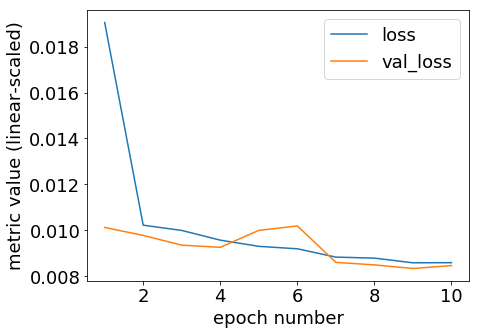

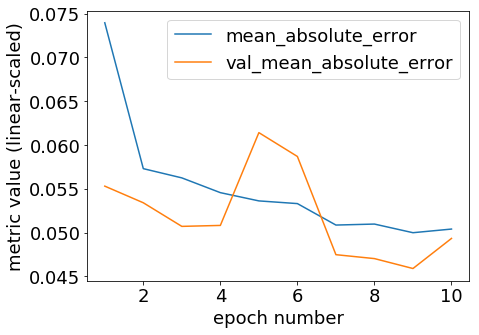

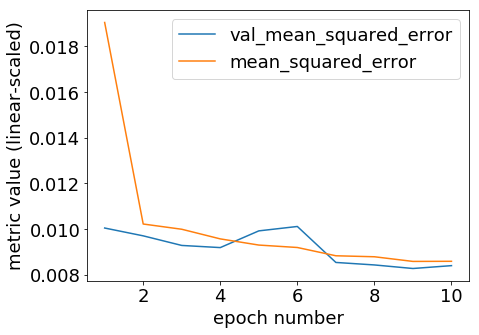

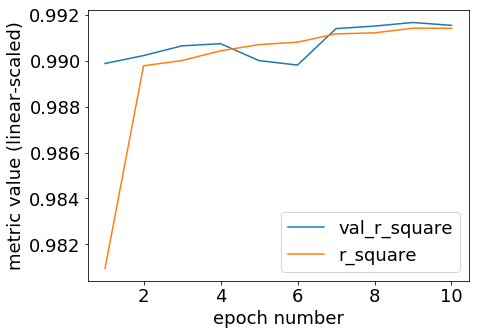

In [16]:
instance.plot_metrics(fnmatch_criteria="*loss*", yscale="linear")
instance.plot_metrics(fnmatch_criteria="*absolute*", yscale="linear")
instance.plot_metrics(fnmatch_criteria="*squared*", yscale="linear")
instance.plot_metrics(fnmatch_criteria="*r_square*", yscale="linear")

checking results:

In [17]:

errors, recon = utils.get_recon_errors([train_norm, test_norm, data_norm, signal_norm], autoencoder)
(train_err, test_err, data_err, signal_err) = errors
(train_recon, test_recon, data_recon, signal_recon) = recon



data_table :: plotting distrubution(s) for table(s) ["'background' normed to 'train'", "'background' normed to 'train' pred"]


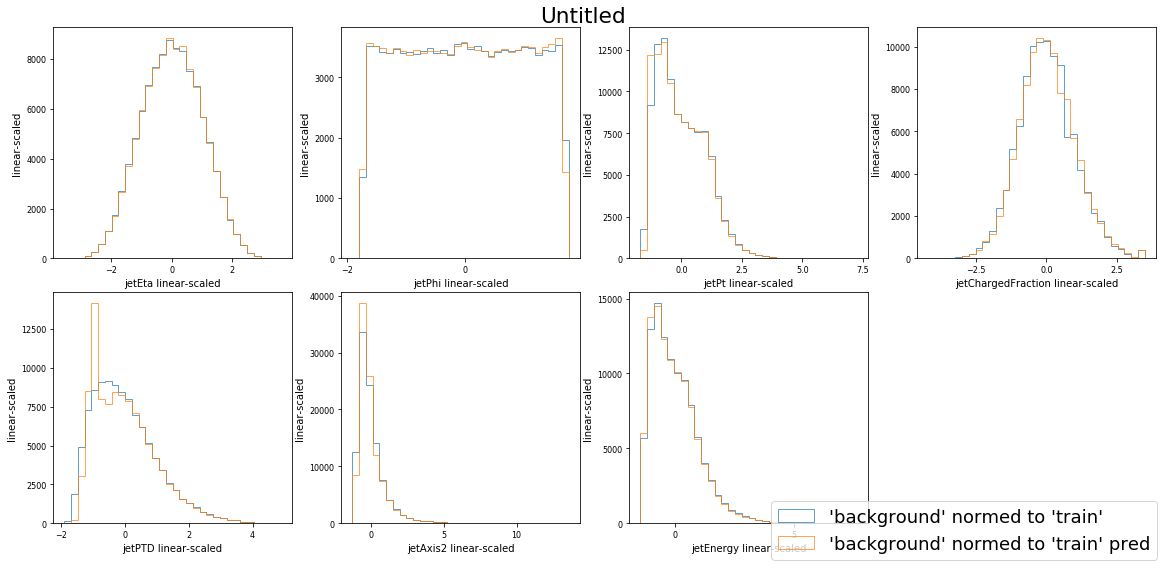

data_table :: plotting distrubution(s) for table(s) ["'signal' normed to 'train'", "'signal' normed to 'train' pred"]


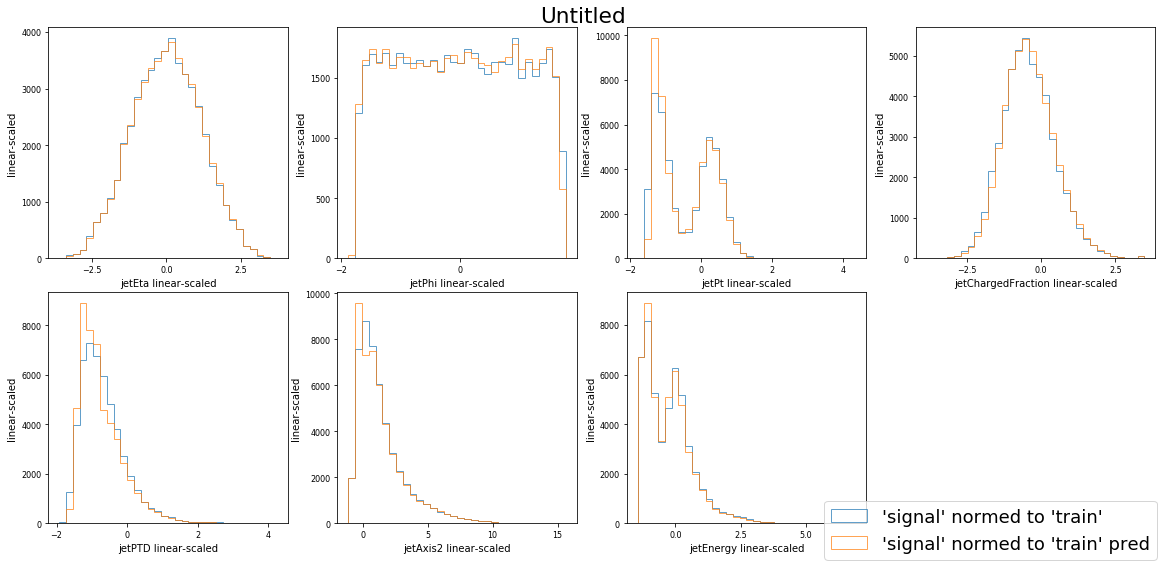

In [18]:
data_norm.plot(data_recon, normed=0)
signal_norm.plot(signal_recon, normed=0)

data_table :: plotting distrubution(s) for table(s) ["'background' normed to 'train' error", "'signal' normed to 'train' error"]


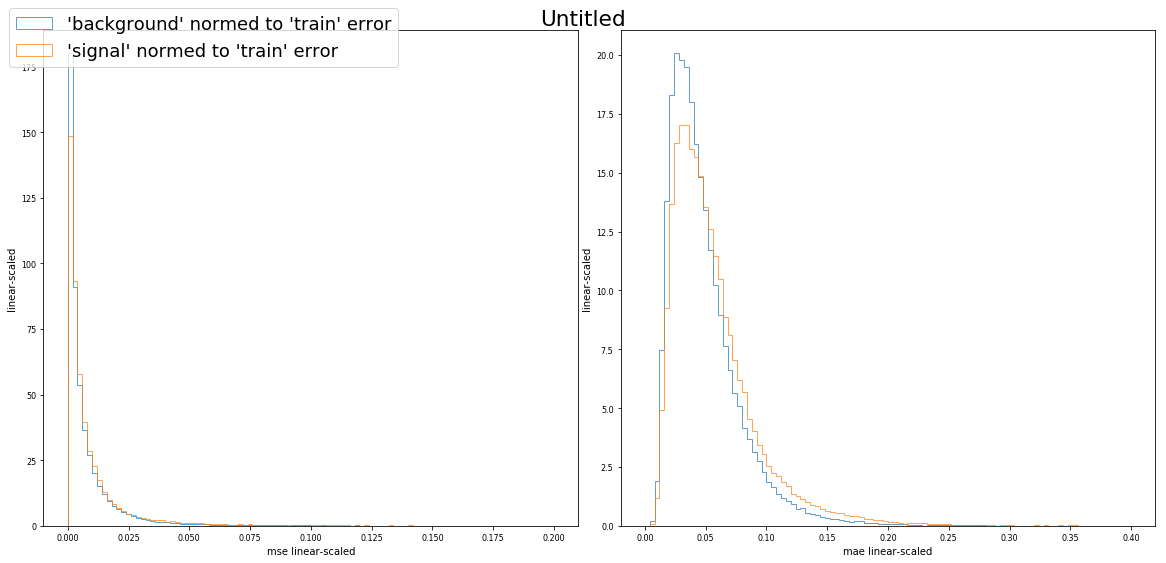

auc value: 0.567617287529


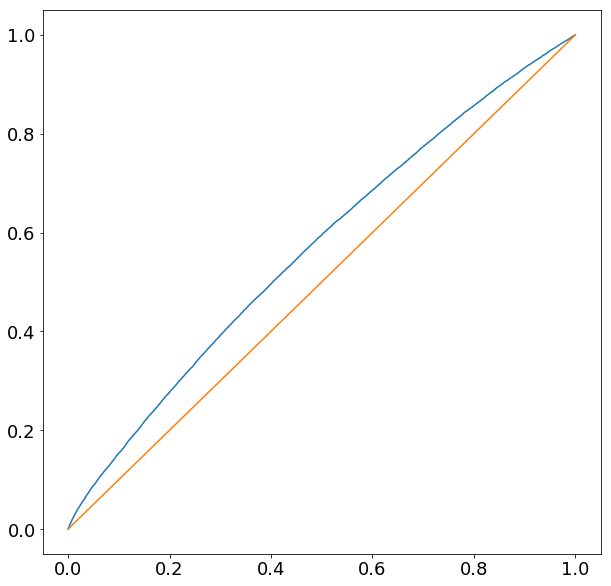

{'auc': 0.56761728752862561,
 'roc': (array([  0.00000000e+00,   1.93393672e-05,   1.93393672e-05, ...,
           9.99951652e-01,   9.99951652e-01,   1.00000000e+00]),
  array([  2.01954924e-05,   2.01954924e-05,   4.03909847e-05, ...,
           9.99979805e-01,   1.00000000e+00,   1.00000000e+00]),
  array([ 0.61492384,  0.54253643,  0.49358679, ...,  0.00560578,
          0.00545162,  0.00381799]))}

In [19]:
data_err.plot(signal_err, figloc="upper left", bins=100, rng=((0,.2), (0, 0.4)), normed=1)
utils.roc_auc_plot(data_err, signal_err)